# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats

In [2]:
crime_raw = pd.read_csv("data/crime rate/crime_data.csv")
homeless_raw = pd.read_csv("data/homelessness/homeless_data.csv")
estate_raw = pd.read_csv("data/housing prices/housing_data.tsv000", sep="\t")

Creating a new dataframe for my crime data that will contain the features I will be working with. The data frame will contain the columns "report_year, population, homicides, assaults, robberies" from my original dataframe. I will be dropping the columns that are not needed for my analysis. I will also adding new columns "state" and "total_crime".

In [3]:
# Removing columns as I am not going to use
crime_df = crime_raw.drop(columns=["agency_code","violent_crimes","rapes","months_reported","crimes_percapita","homicides_percapita","rapes_percapita","assaults_percapita","robberies_percapita"])

# Taking the "city, state" format and removing the city name and renaming year
crime_df["state"] = crime_df["agency_jurisdiction"].apply(lambda x: x.split(",")[-1].strip())
state_crime_df = crime_df.drop(columns=["agency_jurisdiction"])
state_crime_df.rename(columns={"report_year": "year"}, inplace=True)

# Grouping data by state and report year
state_crime_df = state_crime_df.groupby(["state","year"]).sum().reset_index()

# Creating a total crime column that has the sum of all crimes that can be related to monetary motives
state_crime_df["total_crime"] = state_crime_df["homicides"] + state_crime_df["assaults"] + state_crime_df["robberies"]

print(state_crime_df.head(5))


  state  year  population  homicides  assaults  robberies  total_crime
0    AZ  1975   1121722.0      100.0    3413.0     2743.0       6256.0
1    AZ  1976   1110695.0       82.0    3030.0     2128.0       5240.0
2    AZ  1977   1105100.0      109.0    3456.0     2227.0       5792.0
3    AZ  1978   1130900.0      118.0    4036.0     2736.0       6890.0
4    AZ  1979   1149692.0      107.0    4579.0     3187.0       7873.0


Now it's time for the homeless data, I will first drop the unnecessary columns "CoC Number" and "CoC Name". Then I will format the Year column as in the csv file it is written by 1/1/year, whereas working with just the year is easier. After this point I will fix the "Count" column as in some incidents the count is recorded as strings, which I will convert into floats. And lastly the most complex part, In the "Measures" column there are so many categories like "Chronically Homeless Individuals", "Unsheltered Homeless People in Families", "Total Homeless", "Unsheltered Homeless" etc. From those I will first choose the categories that I thinkt the most important ones are, then I will take those I choose and make them a column with the values from "Count"


In [4]:

# Dropping unnecessary columns
hmls_df = homeless_raw.drop(columns=["CoC Number", "CoC Name"])

# Reformatting the year format from 1/1/year to just year
hmls_df["Year"] = hmls_df["Year"].str.split("/").str[-1].astype(int)

# Renaming year and state
hmls_df.rename(columns={"Year": "year"}, inplace=True)
hmls_df.rename(columns={"State": "state"}, inplace=True)

# Changing string values to numerical values
hmls_df["Count"] = hmls_df["Count"].str.replace(",", "").astype(float)
hmls_df["Count"] = pd.to_numeric(hmls_df["Count"], errors="coerce")

# Get the measure types for rearranging the data frame
all_measure_types = hmls_df["Measures"].unique()
measure_types_to_keep = ["Homeless Individuals", "Homeless People in Families", "Total Homeless"]



hmls_df = hmls_df.pivot_table(
    index=["year", "state"],
    columns="Measures",
    values="Count",
    aggfunc="sum",  # Aggregate duplicates (sum them)
    fill_value=0    # Fill missing combinations with 0
).reindex(columns=measure_types_to_keep).reset_index()

#print(pivoted_df)
print(hmls_df.head(5))



Measures  year state  Homeless Individuals  Homeless People in Families  \
0         2007    AK                1062.0                        580.0   
1         2007    AL                4184.0                       1268.0   
2         2007    AR                2987.0                        849.0   
3         2007    AZ               10020.0                       4626.0   
4         2007    CA              110952.0                      28034.0   

Measures  Total Homeless  
0                 1642.0  
1                 5452.0  
2                 3836.0  
3                14646.0  
4               138986.0  


Now it's time for my last dataframe, estate prices.This is the biggest data I have, so arranging it to my liking will be harder than the first two dataframes. The date is stored as periods with a period start and period end date, every period is from that months start to its end. I will combine the two columns, making a new one that only stores the year and month. After this I will discard the columns regarding the location except the "state_code" column. Next I will store property_type and property_type_id to see which kind of estate we are talking about. Lastly I will keep the columns "median_sale_price" and "median_list_price" for price comparison, and "homes_sold" and "new_listings" for state of market comparison.

In [5]:
# Drop the columns
estate_columns_to_keep = ["period_begin","state_code","property_type","median_sale_price","median_list_price","homes_sold","new_listings"]
estate_columns_to_drop = list(set(estate_raw.columns) - set(estate_columns_to_keep))
estate_df = estate_raw.drop(columns=estate_columns_to_drop)

# Transform the format of period column
estate_df["year"] = estate_df["period_begin"].str.split("-").str[0]
estate_df["month"] = estate_df["period_begin"].str.split("-").str[1]
estate_df = estate_df.drop(columns="period_begin")


# Adding property_types to headers
estate_types = estate_df['property_type'].unique()

# Renaming state_code as state
estate_df.rename(columns={'state_code': 'state'}, inplace=True)

print(estate_df["property_type"].unique())

# Turning years and months into integer
estate_df["year"] = estate_df["year"].astype(int)
estate_df["month"] = estate_df["month"].astype(int)

# Grouping data as there are duplicates after we dropped regions
estate_df = estate_df.groupby(
    ['state', 'year', 'month', 'property_type'], as_index=False
).agg({
    'homes_sold': 'sum',
    'new_listings': 'sum',
    'median_sale_price': 'mean',
    'median_list_price': 'mean'
})



# Arranging the data so we deal with years and not months
estate_df = estate_df.drop(columns="month")

estate_df = estate_df.groupby(
    ['year', 'state' ], as_index=False
).agg({
    'homes_sold': 'sum',
    'new_listings': 'sum',
    'median_sale_price': 'mean',
    'median_list_price': 'mean'
})

print(len(estate_df))
print(estate_df.head(5))
print(estate_df["year"].unique())






['Multi-Family (2-4 Unit)' 'Single Family Residential' 'All Residential'
 'Townhouse' 'Condo/Co-op']
714
   year state  homes_sold  new_listings  median_sale_price  median_list_price
0  2012    AK     10910.0       15050.0      211519.998015      235736.431251
1  2012    AL     49104.0       54073.0      118249.794466      160147.764521
2  2012    AR     16194.0       16776.0      123190.090413      151502.740244
3  2012    AZ    212738.0      245528.0      143083.086237      205804.250019
4  2012    CA    770323.0      781882.0      369220.876496      448986.380140
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]


Now let's find the 5 states with the most crime in 2007 and graph their crime count until 2015

In [6]:
# Looking at 2007 to compare
crime_2007 = state_crime_df[state_crime_df["year"] == 2007]
print("The top 5 states with the highest crime rate in 2007:")
print(crime_2007.sort_values(by="total_crime", ascending=False).head(5)[["state", "total_crime"]])



The top 5 states with the highest crime rate in 2007:
     state  total_crime
73      CA      68707.0
934     NY      56588.0
1180    TX      55731.0
319     IL      33292.0
196     FL      29822.0


We found that the top 5 are the states 'CA', 'NY', 'TX', 'IL', 'FL', now let's graph them

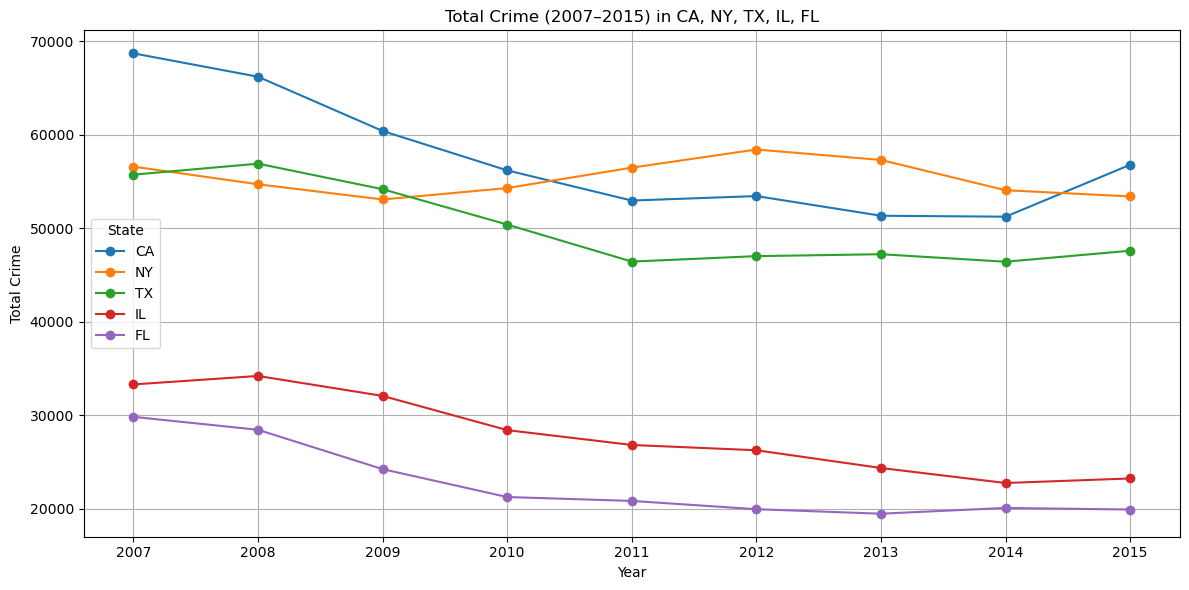

In [7]:
states = ['CA', 'NY', 'TX', 'IL', 'FL']

CA_crime_data = state_crime_df[(state_crime_df["state"] == "CA") & (state_crime_df["year"] >= 2007) & (state_crime_df["year"] <= 2015)]
NY_crime_data = state_crime_df[(state_crime_df["state"] == "NY") & (state_crime_df["year"] >= 2007) & (state_crime_df["year"] <= 2015)]
TX_crime_data = state_crime_df[(state_crime_df["state"] == "TX") & (state_crime_df["year"] >= 2007) & (state_crime_df["year"] <= 2015)]
IL_crime_data = state_crime_df[(state_crime_df["state"] == "IL") & (state_crime_df["year"] >= 2007) & (state_crime_df["year"] <= 2015)]
FL_crime_data = state_crime_df[(state_crime_df["state"] == "FL") & (state_crime_df["year"] >= 2007) & (state_crime_df["year"] <= 2015)]

states_list = [CA_crime_data, NY_crime_data, TX_crime_data, IL_crime_data, FL_crime_data]


# Plot
plt.figure(figsize=(12, 6))
for state in states_list:
    plt.plot(state["year"], state["total_crime"], marker='o', label=state["state"].unique())

plt.title('Total Crime (2007–2015) in CA, NY, TX, IL, FL')
plt.xlabel('Year')
plt.ylabel('Total Crime')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()

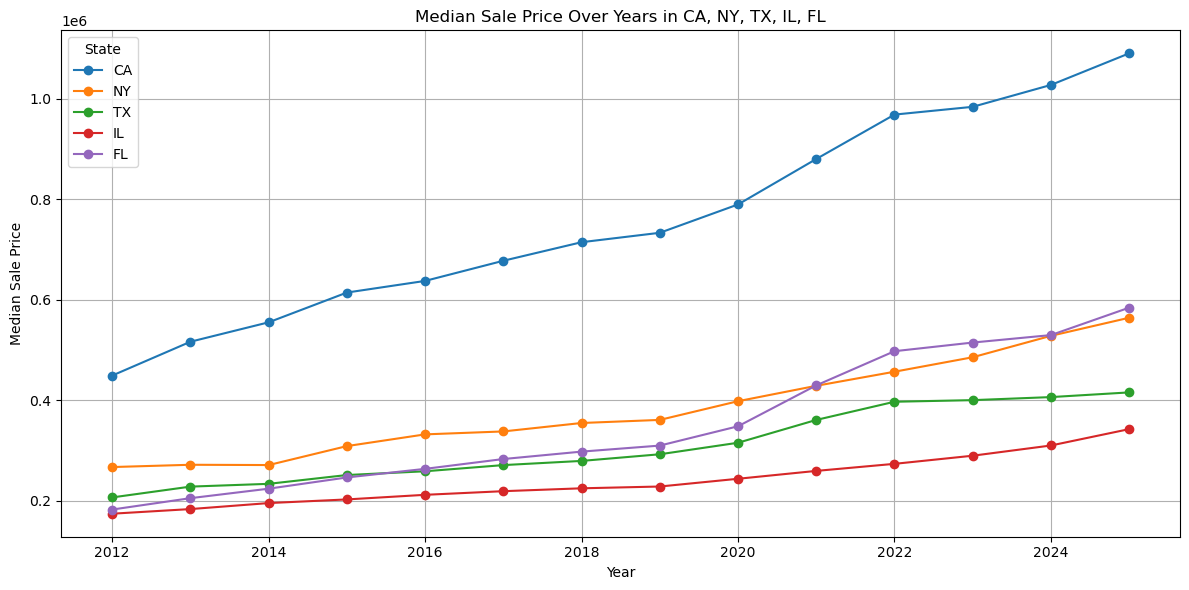

In [8]:
# Filter and group for each state
CA_estate_data = estate_df[(estate_df["state"] == "CA")]
NY_estate_data = estate_df[(estate_df["state"] == "NY")]
TX_estate_data = estate_df[(estate_df["state"] == "TX")]
IL_estate_data = estate_df[(estate_df["state"] == "IL")]
FL_estate_data = estate_df[(estate_df["state"] == "FL")]

states_list = [CA_estate_data, NY_estate_data, TX_estate_data, IL_estate_data, FL_estate_data]

# Plot
plt.figure(figsize=(12, 6))
for state in states_list:
    label = state["state"].iloc[0]
    plt.plot(state["year"], state["median_list_price"], marker='o', label=label)

plt.title('Median Sale Price Over Years in CA, NY, TX, IL, FL')
plt.xlabel('Year')
plt.ylabel('Median Sale Price')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()

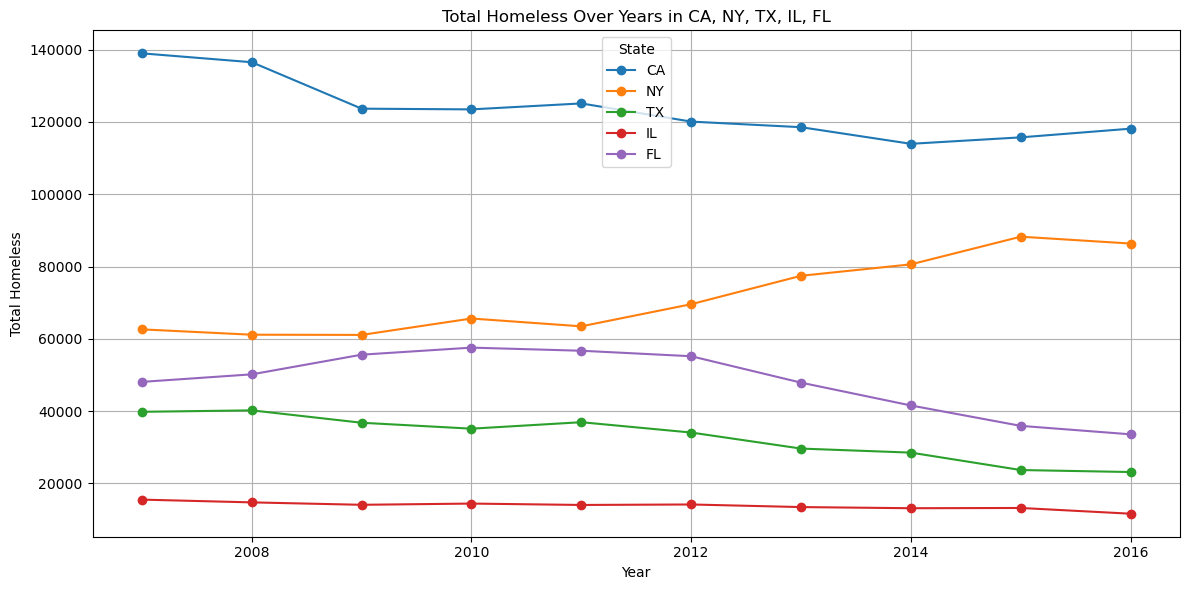

In [9]:
CA_homeless_data = hmls_df[(hmls_df["state"] == "CA")]
NY_homeless_data = hmls_df[(hmls_df["state"] == "NY")]
TX_homeless_data = hmls_df[(hmls_df["state"] == "TX")]
IL_homeless_data = hmls_df[(hmls_df["state"] == "IL")]
FL_homeless_data = hmls_df[(hmls_df["state"] == "FL")]

states_list = [CA_homeless_data, NY_homeless_data, TX_homeless_data, IL_homeless_data, FL_homeless_data]

# Plot
plt.figure(figsize=(12, 6))
for state in states_list:
    label = state["state"].iloc[0]
    plt.plot(state["year"], state["Total Homeless"], marker='o', label=label)

plt.title('Total Homeless Over Years in CA, NY, TX, IL, FL')
plt.xlabel('Year')
plt.ylabel('Total Homeless')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()

Now let's take a look at CA in the same graph 

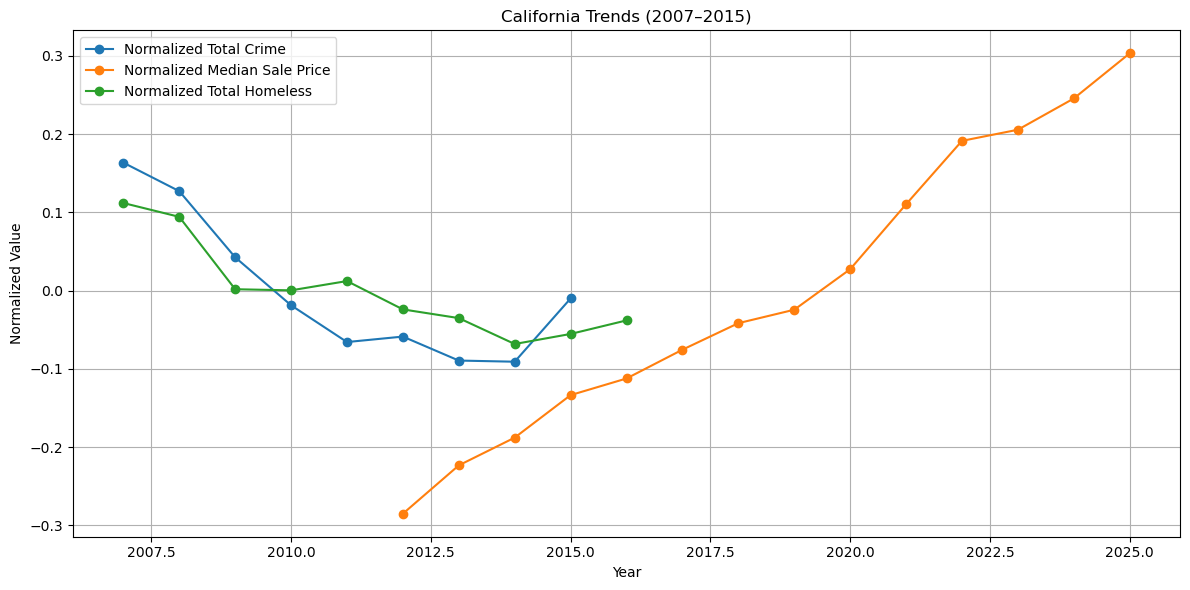

In [10]:

CA_crime_norm = (CA_crime_data["total_crime"] - CA_crime_data["total_crime"].mean()) / CA_crime_data["total_crime"].max()
CA_price_norm = (CA_estate_data["median_list_price"] - CA_estate_data["median_list_price"].mean()) / CA_estate_data["median_list_price"].max()
CA_homeless_norm = (CA_homeless_data["Total Homeless"] - CA_homeless_data["Total Homeless"].mean()) / CA_homeless_data["Total Homeless"].max()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(CA_crime_data["year"], CA_crime_norm, marker='o', label="Normalized Total Crime")
plt.plot(CA_estate_data["year"], CA_price_norm, marker='o', label="Normalized Median Sale Price")
plt.plot(CA_homeless_data["year"], CA_homeless_norm, marker='o', label="Normalized Total Homeless")

plt.title("California Trends (2007–2015)")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now let's see how the sum of all states behave

In [31]:

# Merging datasets by groups of 2
crime_estate_df = pd.merge(state_crime_df, estate_df, on=['state', 'year'], how='inner')
crime_homeless_df = pd.merge(state_crime_df, hmls_df, on=['state', 'year'], how='inner')
homeless_estate_df = pd.merge(hmls_df, estate_df, on=['state', 'year'], how='inner')

# Normalizing the values
def z_score_normalize(df, cols):
    df_norm = df.copy()
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        df_norm[col] = (df[col] - mean) / std
    return df_norm


crime_estate_cols = ["total_crime", "median_list_price"]
crime_homeless_cols = ["total_crime", "Total Homeless"]
homeless_estate_cols = ["Total Homeless", "median_list_price"]


crime_estate_df = z_score_normalize(crime_estate_df, crime_estate_cols)
crime_homeless_df = z_score_normalize(crime_homeless_df, crime_homeless_cols)
homeless_estate_df = z_score_normalize(homeless_estate_df, homeless_estate_cols)


Null Hypothesis 1) Estate prices does not affect crime rate
<br> Alternate Hypothesis 1) Estate prices affect crime rate

In [32]:
# Calculating with pearson
r1, p1 = pearsonr(crime_estate_df['median_list_price'], crime_estate_df['total_crime'])

print(f"Estate vs Crime: r = {r1:.3f}, p = {p1:.3e}")

Estate vs Crime: r = 0.161, p = 6.516e-02


Null Hypothesis 2) Crime rate does not affect homeless count
<br>Alternate Hypothesis 2) Crime rate affects homeless count

In [33]:
# Calculating with pearson
r2, p2 = pearsonr(crime_homeless_df['total_crime'], crime_homeless_df['Total Homeless'])

print(f"Crime vs Homeless: r = {r2:.3f}, p = {p2:.3e}")

Crime vs Homeless: r = 0.806, p = 4.859e-69


Null Hypothesis 3) Estate prices does not affect homeless count
<br>Alternate Hypothesis 3) Estate prices affect homeless count

In [38]:
# Calculating with pearson
r3, p3 = pearsonr(homeless_estate_df['median_list_price'], homeless_estate_df['Total Homeless'])

print(f"Estate vs Homeless: r = {r3:.3f}, p = {p3:.3e}")

Estate vs Homeless: r = 0.374, p = 0.00000


Let's plot those 3

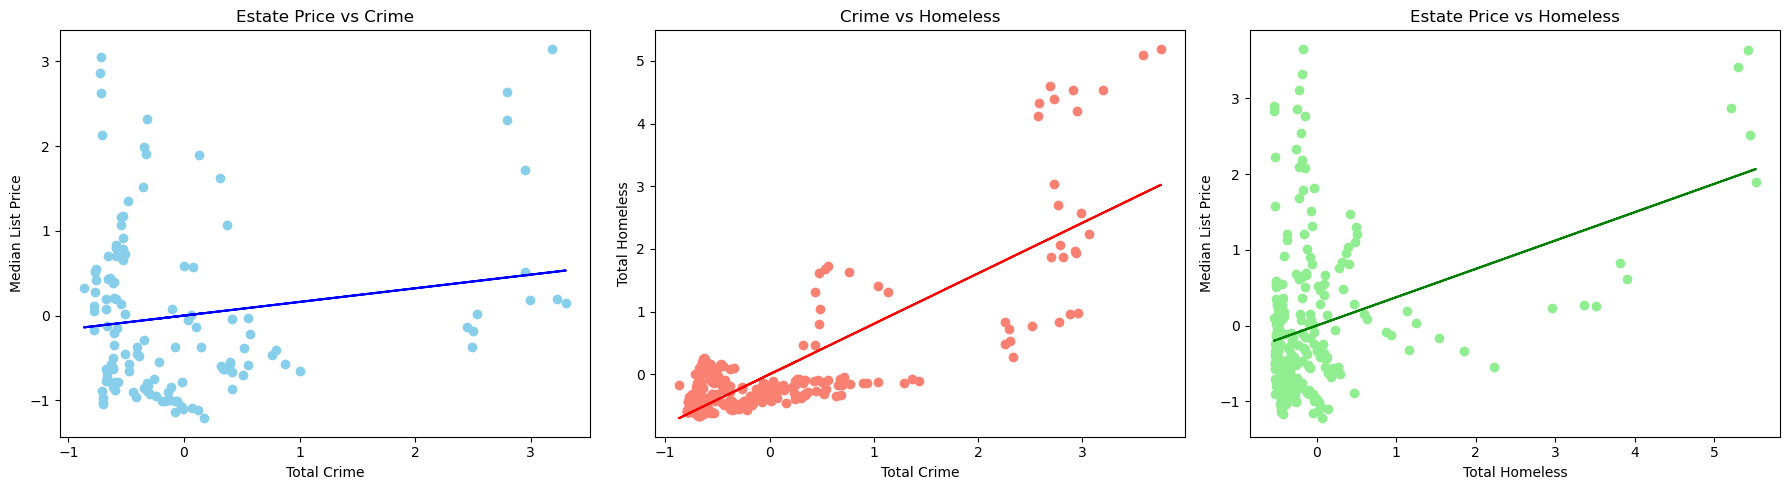

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Estate vs Crime
x1 = crime_estate_df["total_crime"]
y1 = crime_estate_df["median_list_price"]
slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
axes[0].scatter(x1, y1, color='skyblue')
axes[0].plot(x1, slope1 * x1 + intercept1, color='blue')
axes[0].set_title('Estate Price vs Crime')
axes[0].set_xlabel('Total Crime')
axes[0].set_ylabel('Median List Price')

# Plot 2: Crime vs Homeless
x2 = crime_homeless_df["total_crime"]
y2 = crime_homeless_df["Total Homeless"]
slope2, intercept2, _, _, _ = stats.linregress(x2, y2)
axes[1].scatter(x2, y2, color='salmon')
axes[1].plot(x2, slope2 * x2 + intercept2, color='red')
axes[1].set_title('Crime vs Homeless')
axes[1].set_xlabel('Total Crime')
axes[1].set_ylabel('Total Homeless')

# Plot 3: Estate vs Homeless
x3 = homeless_estate_df["Total Homeless"]
y3 = homeless_estate_df["median_list_price"]
slope3, intercept3, _, _, _ = stats.linregress(x3, y3)
axes[2].scatter(x3, y3, color='lightgreen')
axes[2].plot(x3, slope3 * x3 + intercept3, color='green')
axes[2].set_title('Estate Price vs Homeless')
axes[2].set_xlabel('Total Homeless')
axes[2].set_ylabel('Median List Price')

plt.tight_layout()
plt.show()

Looking at the r and p values, we can say that:

<br> In case 1 we fail to reject the null hypothesis as our p value is greater than 0.05
<br> In case 2 ve reject the null hypothesis as our p value is less than 0.05 and there is a major positive correlation (r = 0.806)
<br> In case 3 we reject the null hypothesis as our p value is less than 0.05 and there is a moderate positive correlation ( r = 0.374)